# Modeling Code Modularization

This notebook work on putting this notebook https://dagshub.com/Omdena/Glintsolar/src/preprocessing_GreatLake/preprocessing/notebooks/RF_estimate_bathymetry.ipynb into production code.

In [7]:
import rioxarray as rxr
import numpy as np
import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle
from pathlib import Path

In [2]:
def tiff_to_model_input(file):
    """
    This function takes image from file, transform the image input into numpy format for model input.
    
    Parameter:
    File(str): filename (including file directory)
    """
    # Load in file
    data = rxr.open_rasterio(file)
    data_numpy = data.copy().to_numpy()
    
    # Shuffle the pixels the separate them into train set and test set
    lon_indices = list(range(data_numpy.shape[1]))
    lat_indices = list(range(data_numpy.shape[2]))
    train_lon_indices, test_lon_indices = train_test_split(lon_indices, test_size=0.2, random_state=42)
    train_lat_indices, test_lat_indices = train_test_split(lat_indices, test_size=0.2, random_state=42)
    # Train data
    train = data_numpy[:,train_lon_indices, :]
    train = train[:,:,train_lat_indices]
    # Test data
    test = data_numpy[:,test_lon_indices, :]
    test = test[:,:,test_lat_indices]
    
    target_indice = (test.shape[0]) - 1
    
    # Target
    y_train = train[target_indice,:,:]
    y_test = test[target_indice:,:,]
    # Features
    X_train = train[:target_indice,:,:]
    X_test = test[:target_indice,:,:]
    
    # Reshape dimension to 2D due to acceptance of input format of RF model
    # training data 
    X_train_2D = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
    X_train = np.nan_to_num(X_train_2D)                            # Turn NaN into 0
    
    y_train_1D = y_train.reshape(y_train.shape[0]*y_train.shape[1])
    y_train = np.nan_to_num(y_train_1D)                            # Turn NaN into 0
    
    # test data
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
    X_test = np.nan_to_num(X_test)                            # Turn NaN into 0
    
    y_test = y_test.reshape(y_test.shape[1]*y_test.shape[2])
    y_test = np.nan_to_num(y_test)                            # Turn NaN into 0
    
    
    
    return X_train, y_train, X_test, y_test

In [3]:
def rf_model(X_train, y_train):
    """
    This function takes the training data to train Random Forest model.
    
    Parameters:
    X_train: train data without target; output from tiff_to_model_input
    y_train: train data target; output from tiff_to_model_input
    
    """
    # Initialize Random Forest Regressor Model
    rf = RandomForestRegressor(random_state=42)
    # Train model
    rf_model = rf.fit(X_train.transpose(), y_train)
    #save model
    
    return rf_model

In [4]:
def model_metric(rf_model, X_test, y_test):
    """
    This function returns the mean absolute error as model performance for the model
    
    Parameters:
    rf_model: random forest model trained with rf_model function
    X_test: test data without target; output from tiff_to_model_input
    y_test: test data target; output from tiff_to_model_input
    
    """
    # Prediction
    prediction = rf_model.predict(X_test.transpose())
    # Scoring model performance - Mean Absolute Error
    mae = mean_absolute_error(y_test, prediction)
    
    return mae

In [5]:
X_train, y_train, X_test, y_test = tiff_to_model_input('../preprocessing/data/swanson/202010_1yr_median_clipped.tif')
RFmodel = rf_model(X_train, y_train)
mae = model_metric(RFmodel, X_test, y_test)
print(mae)

0.24440948682783492


In [9]:
# Save the model to disk
dirpath = 'models/'
model_name = 'RF.sav'
Path(dirpath).mkdir(parents=True, exist_ok=True)
MDfilename = dirpath + model_name
pickle.dump(RFmodel, open(MDfilename, 'wb'))

In [10]:
# Load the model from disk
loaded_model = pickle.load(open(MDfilename, 'rb'))
result = model_metric(loaded_model, X_test, y_test)
print(result)

0.24440948682783492


# Analyze Data

In [13]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set()


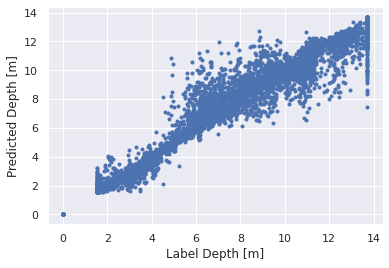

In [74]:
prediction = loaded_model.predict(X_test.transpose())

plt.xlabel('Label Depth [m]')
plt.ylabel('Predicted Depth [m]')
plt.plot(y_test, prediction, '.')

#### Prediction in deeper area works not so well from the scatter plot.

(array([7739.,  666.,  433.,  405.,  637.,  697.,  713.,  839.,  762.,
         306.]),
 array([ 0.    ,  1.3716,  2.7432,  4.1148,  5.4864,  6.858 ,  8.2296,
         9.6012, 10.9728, 12.3444, 13.716 ]),
 <BarContainer object of 10 artists>)

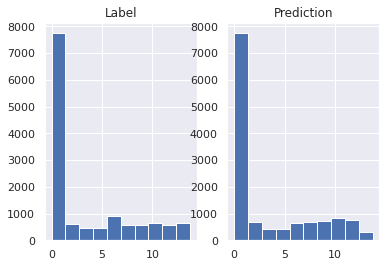

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Label')
ax[1].set_title('Prediction')
ax[0].hist(y_test)
ax[1].hist(prediction)

#### Plot the data without 0

(array([423., 341., 310., 288., 280., 587., 485., 487., 607., 597., 495.,
        507.,  51.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 13 artists>)

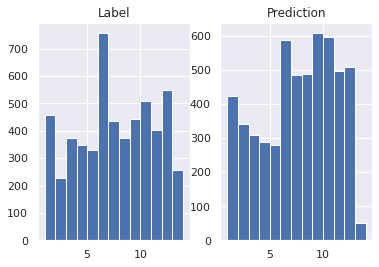

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Label')
ax[1].set_title('Prediction')
ax[0].hist(y_test, bins=[i for i in range(1,round(y_test.max())+1)])
ax[1].hist(prediction, bins=[i for i in range(1,round(y_test.max())+1)])

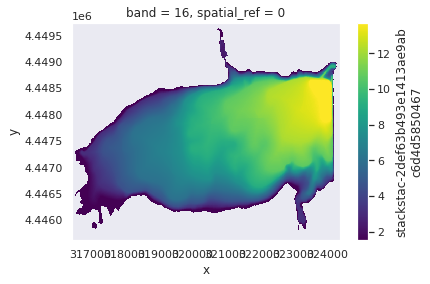

In [61]:
# Plot the bathymetric prediction

src = rxr.open_rasterio('../preprocessing/data/swanson/202010_1yr_median_clipped.tif')
src.isel(band=src.shape[0]-1).plot() # Ground truth

In [102]:
target = src.sel(band=src.shape[0]).to_numpy()
X_without_shuffled = src.drop_sel(band=src.shape[0]).to_numpy()

In [103]:
features, bathy_x, bathy_y = X_without_shuffled.shape

In [104]:
X_without_shuffled = X_without_shuffled.reshape((features, bathy_x*bathy_y))
X_without_shuffled = np.nan_to_num(X_without_shuffled)

In [105]:
X_without_shuffled.shape

(15, 326716)

In [123]:
pred_ordered = loaded_model.predict(X_without_shuffled.transpose())

In [124]:
target_1D = np.nan_to_num(target.reshape(bathy_x*bathy_y))

In [125]:
mean_absolute_error(pred_ordered, target_1D)

0.13252365470801913

/tmp/ipykernel_104/2865423624.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


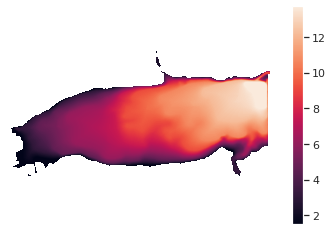

In [77]:
plt.imshow(target)
plt.grid(False)
plt.axis('off')
plt.colorbar()

In [121]:
target_reverse = target_1D.reshape((bathy_x,bathy_y))

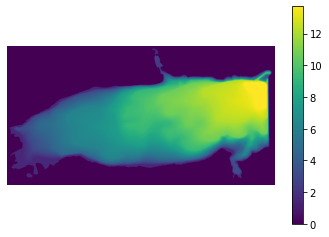

In [122]:
plt.grid(False)
plt.axis('off')
plt.imshow(target_reverse)
plt.colorbar()

In [126]:
pred_ordered_reverse = pred_ordered.reshape((bathy_x, bathy_y))

In [127]:
# pred_ordered_reverse = pred_ordered_reverse.astype('float')
pred_ordered_reverse[pred_ordered_reverse == 0] = np.nan

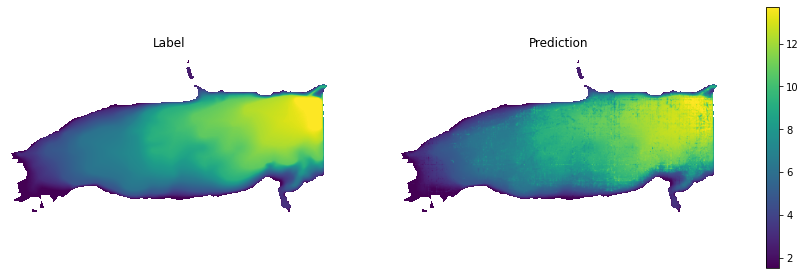

In [168]:
sns.reset_orig()
fig, ax = plt.subplots(1,2, figsize=(16,16))
ax[0].set_title('Label')
ax[1].set_title('Prediction')
ax[0].axis('off')
ax[1].axis('off')
pos = ax[0].imshow(target)
ax[1].imshow(pred_ordered_reverse)
fig.colorbar(pos, ax=ax,shrink=0.3)